# Question 4: Link Prediction

Implémentation et évaluation de trois métriques de prédiction de liens:
1. **Common Neighbors**
2. **Jaccard**
3. **Adamic/Adar**

## Import des bibliothèques

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from abc import ABC, abstractmethod
from tqdm import tqdm
import random

random.seed(42)
np.random.seed(42)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Question 4(b): Implémentation des métriques

Implémentation des 3 métriques en héritant de la classe `LinkPrediction`

In [ ]:
class LinkPrediction(ABC):
    def __init__(self, graph):
        """
        Constructor
        
        Parameters
        ----------
        graph : Networkx graph
        """
        self.graph = graph
        self.N = len(graph)
    
    def neighbors(self, v):
        """
        Return the neighbors list of a node
        
        Parameters
        ----------
        v: int
            node id
        
        Return
        ------
        neighbors_list : python list
        """
        neighbors_list = self.graph.neighbors(v)
        return list(neighbors_list)
    
    @abstractmethod
    def fit(self):
        raise NotImplementedError("Fit must be implemented")

In [ ]:
class CommonNeighbors(LinkPrediction):
    def __init__(self, graph):
        super(CommonNeighbors, self).__init__(graph)
        self.scores = {}
    
    def fit(self):
        """
        Calcule:
        Score(u, v) = |N(u) ∩ N(v)|
        avec N(u) = ensemble des voisins de u
        
        retourne:
        scores : dict
        {(u, v): score}
        """
        nodes = list(self.graph.nodes())
        
        for i, u in enumerate(tqdm(nodes, desc="Common Neighbors")):
            neighbors_u = set(self.neighbors(u))
            
            for v in nodes[i+1:]:
                # Ne calculer que pour les paires non-connectées!!!!!!
                if not self.graph.has_edge(u, v):
                    neighbors_v = set(self.neighbors(v))
                    
                    common = len(neighbors_u & neighbors_v)
                    
                    self.scores[(u, v)] = common
        
        return self.scores

In [ ]:
class Jaccard(LinkPrediction):    
    def __init__(self, graph):
        super(Jaccard, self).__init__(graph)
        self.scores = {}
    
    def fit(self):
        """
        coefficient de Jaccard:
        Score(u, v) = |N(u) ∩ N(v)| / |N(u) ∪ N(v)|
        
        retourne:
        scores : dict
            {(u, v): score}
        """
        nodes = list(self.graph.nodes())
        
        for i, u in enumerate(tqdm(nodes, desc="Jaccard")):
            neighbors_u = set(self.neighbors(u))
            
            for v in nodes[i+1:]:
                if not self.graph.has_edge(u, v):
                    neighbors_v = set(self.neighbors(v))
                    
                    # Intersection et union
                    intersection = len(neighbors_u & neighbors_v)
                    union = len(neighbors_u | neighbors_v)
                    
                    # Éviter division par zéro
                    if union > 0:
                        score = intersection / union
                    else:
                        score = 0.0
                    
                    self.scores[(u, v)] = score
        
        return self.scores

In [ ]:
class AdamicAdar(LinkPrediction):
    def __init__(self, graph):
        super(AdamicAdar, self).__init__(graph)
        self.scores = {}
    
    def fit(self):
        """
        Adamic/Adar
        Score(u, v) = sum (1 / log(|N(w)|)) pour w dans N(u) ∩ N(v)
        
        retourne:
        
        scores : dict
            {(u, v): score}
        """
        nodes = list(self.graph.nodes())
        
        for i, u in enumerate(tqdm(nodes, desc="Adamic/Adar")):
            neighbors_u = set(self.neighbors(u))
            
            for v in nodes[i+1:]:
                if not self.graph.has_edge(u, v):
                    neighbors_v = set(self.neighbors(v))
                    
                    common_neighbors = neighbors_u & neighbors_v
                    
                    score = 0.0
                    for w in common_neighbors:
                        degree_w = len(self.neighbors(w))
                        # on evite log(1) et log(0)
                        if degree_w > 1:
                            score += 1.0 / np.log(degree_w)
                    
                    self.scores[(u, v)] = score
        
        return self.scores

## Question 4(c): Évaluation des prédicteurs

1. Retirer une fraction f d'arêtes (Eremoved)
2. Prédire les arêtes avec chaque métrique (Epredict)
3. Évaluer avec top@k, precision@k, recall@k

In [7]:
def remove_edges(G, fraction):
    """
    renvoie le graphe avec les arêtes retirées et l'ensemble des arêtes retirées
    """
    G_train = G.copy()
    edges = list(G.edges())
    
    n_remove = int(len(edges) * fraction)
    
    removed_edges = set(random.sample(edges, n_remove))
    
    G_train.remove_edges_from(removed_edges)
    
    removed_edges_cleaned = set()
    for u, v in removed_edges:
        removed_edges_cleaned.add((min(u, v), max(u, v)))
        #on ne met pas 2 fois la même arrête de u à v ou de v à u.
    
    return G_train, removed_edges_cleaned

In [8]:
def evaluate_predictions(predicted_edges, removed_edges, k_values):
    """
    retourne top@k, precision@k, recall@k
    """
    results = {}
    
    for k in k_values:
        top_k_edges = set([e for e, score in predicted_edges[:k]])
        
        TP = len(top_k_edges & removed_edges)
        
        FP = len(top_k_edges - removed_edges)
        
        FN = len(removed_edges - top_k_edges)
        
        top_k_rate = TP / k if k > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        results[k] = {
            'top_k': top_k_rate,
            'precision': precision,
            'recall': recall,
            'TP': TP
        }
    
    return results

In [ ]:
def run_link_prediction_experiment(G, predictor_class, predictor_name, fraction, k_values):
    """
    pour lancer une experience de link prediction avec un predictor metric (predictor_name) donnée.
    """
    print(f"Expérience: {predictor_name}, fraction={fraction}")
    
    G_train, removed_edges = remove_edges(G, fraction)

    
    predictor = predictor_class(G_train)
    scores = predictor.fit()
    
    predicted_edges = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    results = evaluate_predictions(predicted_edges, removed_edges, k_values)
    
    return results

## Question 4(d): Expériences sur plusieurs graphes

Évaluation des 3 métriques sur quelques réseaux Facebook100

In [10]:
data_dir = Path("data")

networks_to_test = [
    'Caltech36.gml',
    'Haverford76.gml',
    'Swarthmore42.gml'
]

fractions = [0.05, 0.1, 0.15, 0.2]

k_values = [50, 100, 200, 300, 400]

# Prédicteurs
predictors = [
    (CommonNeighbors, 'Common Neighbors'),
    (Jaccard, 'Jaccard'),
    (AdamicAdar, 'Adamic/Adar')
]

In [ ]:
all_experiments = []

for network_file_name in networks_to_test:
    network_file = data_dir / network_file_name
    network_name = network_file.stem
    
    print(f"reseau: {network_name}")
    
    G = nx.read_gml(network_file)
    print(f"Nœuds: {G.number_of_nodes()}, Arêtes: {G.number_of_edges()}")
    
    #on ne prend que la LCC
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
        print(f"  LCC: {G.number_of_nodes()} nœuds, {G.number_of_edges()} arêtes")
    
    for fraction in fractions:
        
        for predictor_class, predictor_name in predictors:
            print(f"Prédicteur: {predictor_name}")
            
            results = run_link_prediction_experiment(
                G, predictor_class, predictor_name, fraction, k_values
            )
            
            for k in k_values:
                r = results[k]
                all_experiments.append({
                    'network': network_name,
                    'predictor': predictor_name,
                    'fraction': fraction,
                    'k': k,
                    'top_k': r['top_k'],
                    'precision': r['precision'],
                    'recall': r['recall'],
                    'TP': r['TP']
                })


reseau: Caltech36
Nœuds: 769, Arêtes: 16656
  LCC: 762 nœuds, 16651 arêtes

reseau: Haverford76
Nœuds: 1446, Arêtes: 59589

reseau: Swarthmore42
Nœuds: 1659, Arêtes: 61050
  LCC: 1657 nœuds, 61049 arêtes

In [ ]:
df_results = pd.DataFrame(all_experiments)

df_results.to_csv('outputs/question4/all_experiments_results.csv', index=False)

print(df_results.head(20))

In [12]:
df_results = pd.read_csv('outputs/question4/all_experiments_results.csv')

### Visualisation : comparaison des prédicteurs pour chaque réseau

### fraction = 0.05

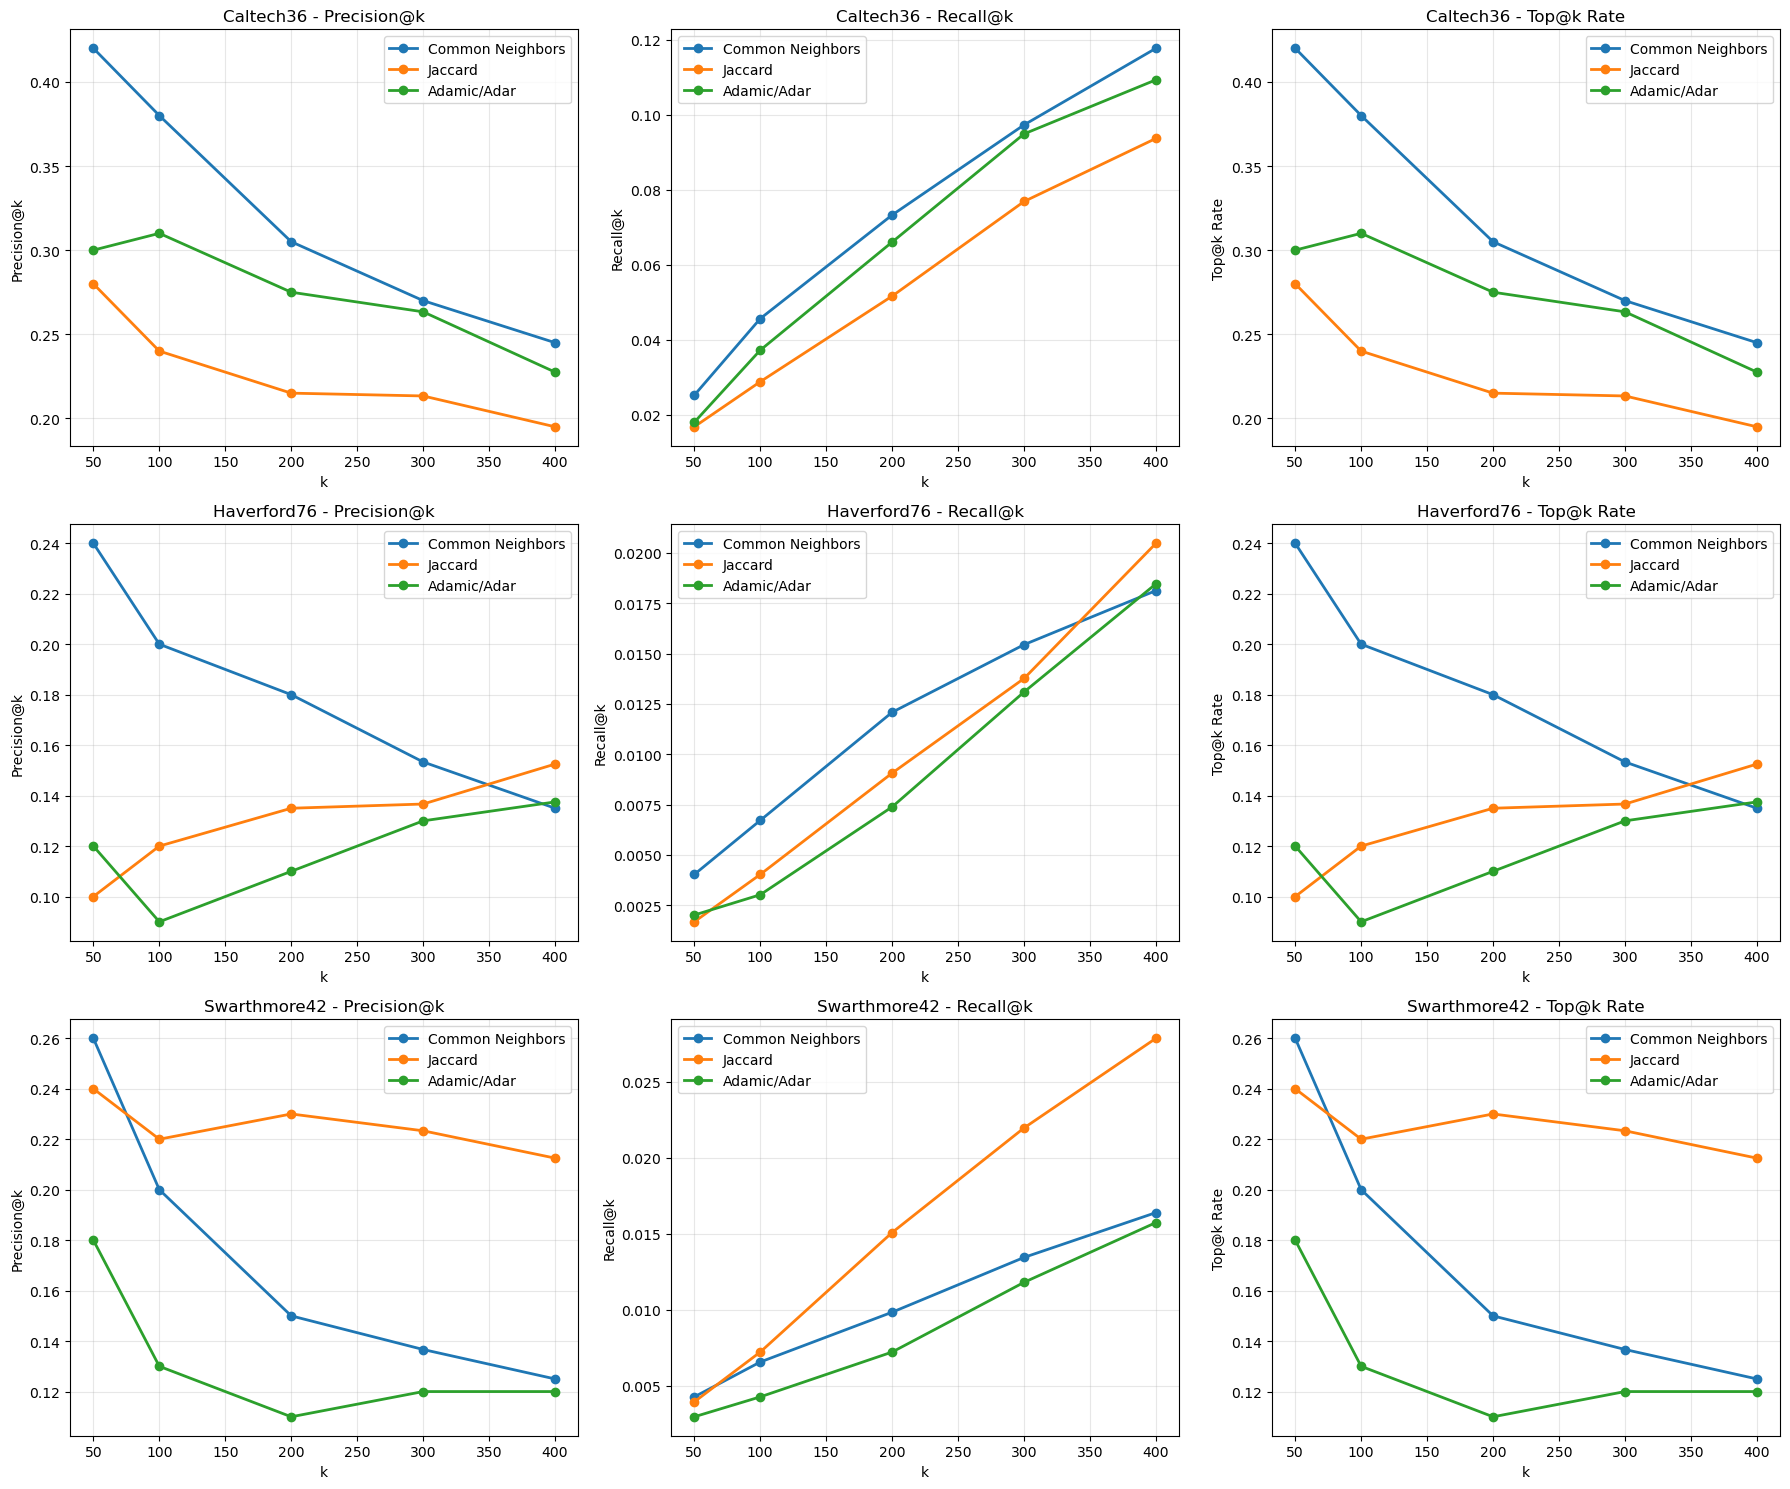

In [15]:
fraction_to_plot = 0.05

fig, axes = plt.subplots(len(networks_to_test), 3, figsize=(18, 5*len(networks_to_test)))

if len(networks_to_test) == 1:
    axes = axes.reshape(1, -1)

metrics_to_plot = ['precision', 'recall', 'top_k']
titles = ['Precision@k', 'Recall@k', 'Top@k Rate']

for net_idx, network_name in enumerate([Path(n).stem for n in networks_to_test]):
    for metric_idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[net_idx, metric_idx]
        
        data_filtered = df_results[
            (df_results['network'] == network_name) & 
            (df_results['fraction'] == fraction_to_plot)
        ]
        
        for predictor in data_filtered['predictor'].unique():
            pred_data = data_filtered[data_filtered['predictor'] == predictor]
            pred_data = pred_data.sort_values('k')
            
            ax.plot(pred_data['k'], pred_data[metric], 
                   marker='o', label=predictor, linewidth=2)
        
        ax.set_xlabel('k')
        ax.set_ylabel(title)
        ax.set_title(f'{network_name} - {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/question4/comparison_predictors_by_network_f_0_05.png', dpi=300, bbox_inches='tight')
plt.show()

### fraction = 0.1

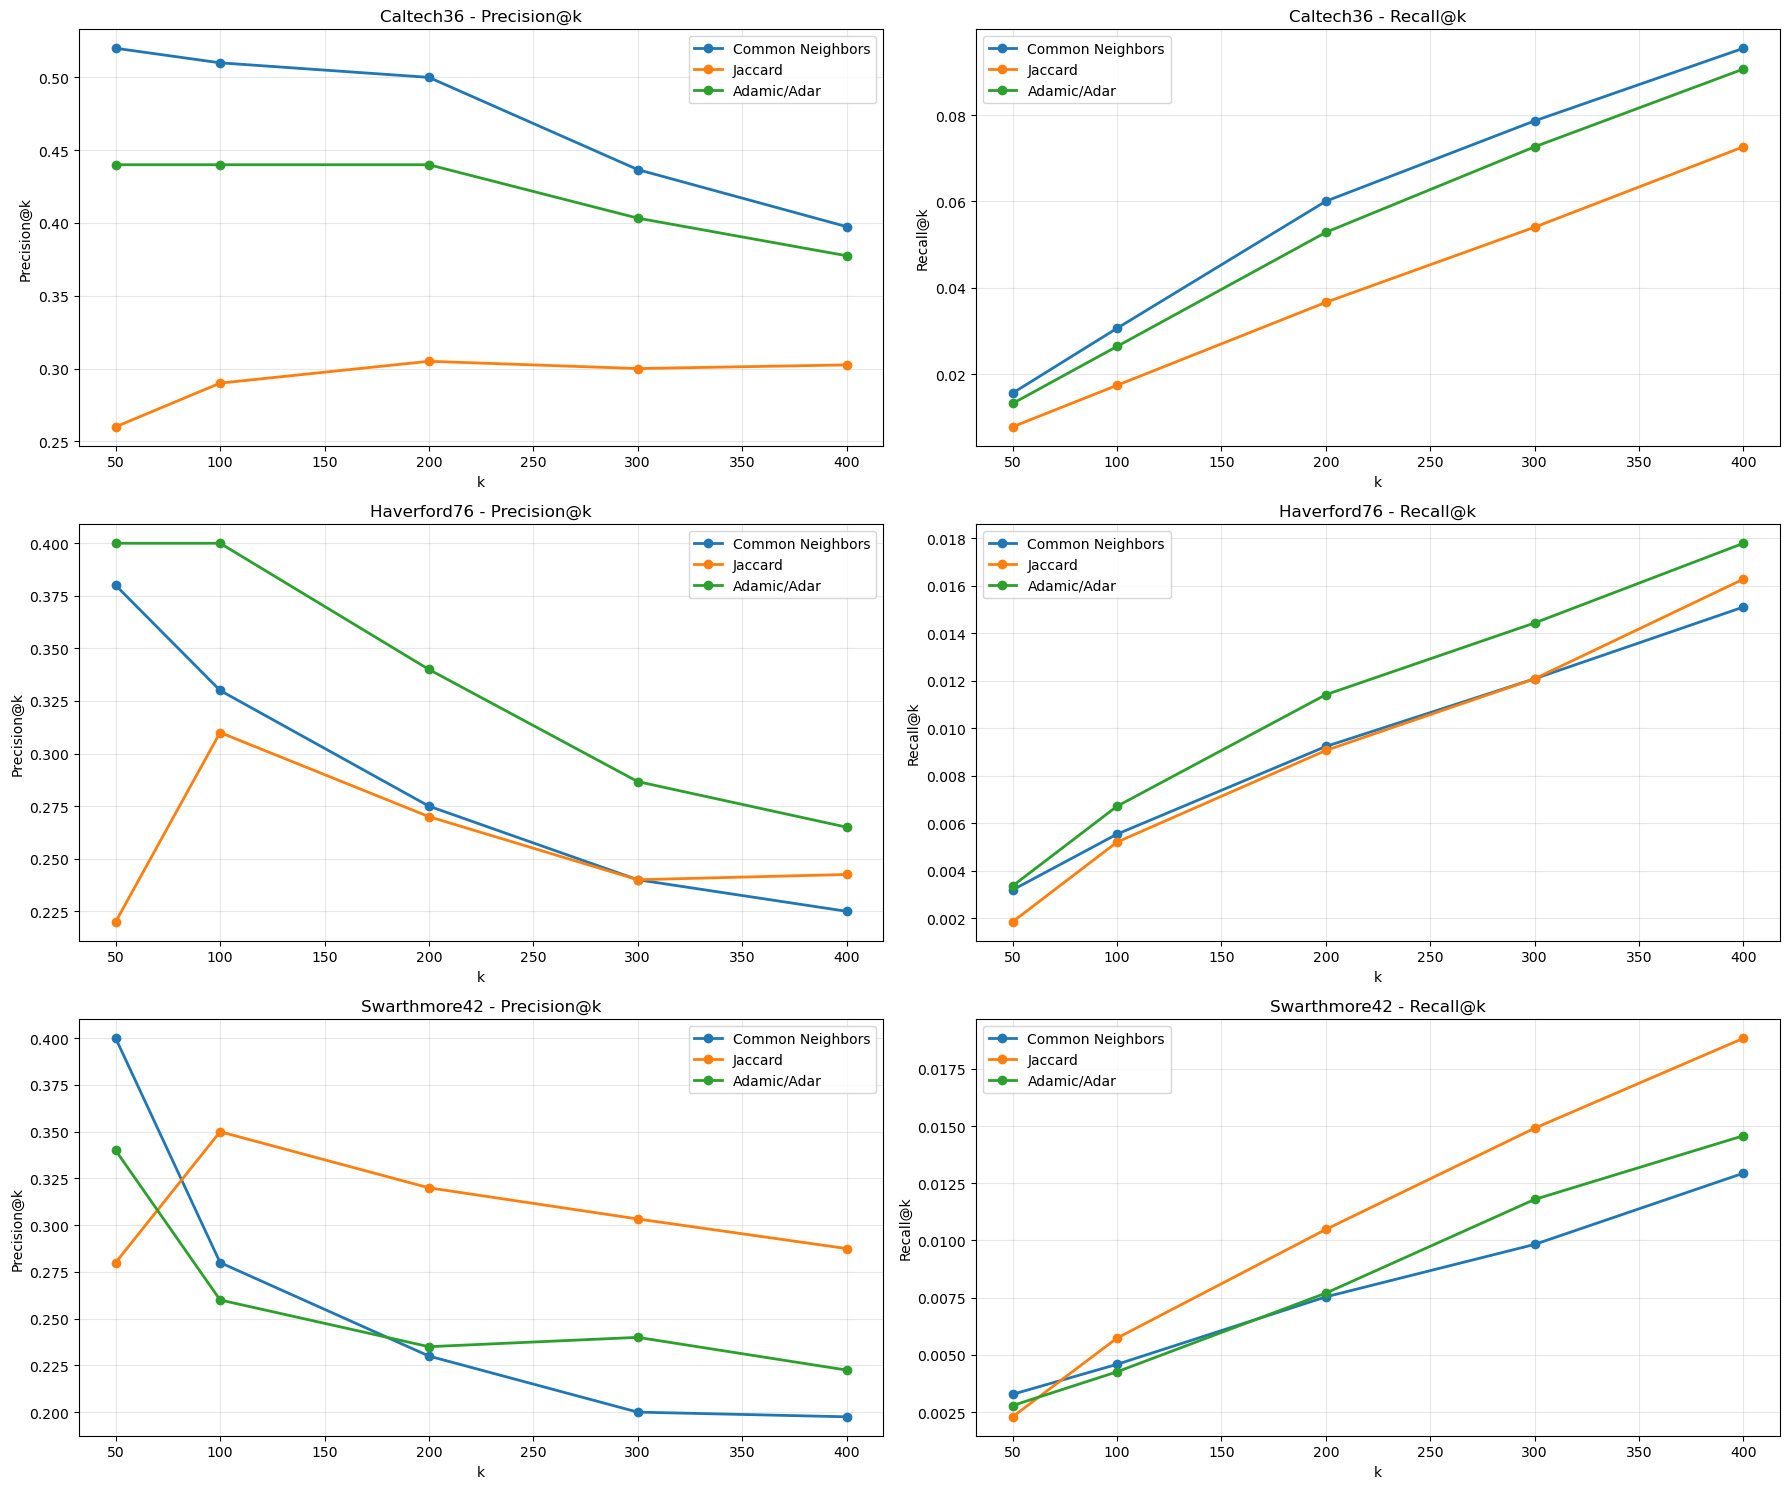

In [14]:
fraction_to_plot = 0.1

fig, axes = plt.subplots(len(networks_to_test), 2, figsize=(18, 5*len(networks_to_test)))

if len(networks_to_test) == 1:
    axes = axes.reshape(1, -1)

metrics_to_plot = ['precision', 'recall']
titles = ['Precision@k', 'Recall@k']

for net_idx, network_name in enumerate([Path(n).stem for n in networks_to_test]):
    for metric_idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[net_idx, metric_idx]
        
        data_filtered = df_results[
            (df_results['network'] == network_name) & 
            (df_results['fraction'] == fraction_to_plot)
        ]
        
        for predictor in data_filtered['predictor'].unique():
            pred_data = data_filtered[data_filtered['predictor'] == predictor]
            pred_data = pred_data.sort_values('k')
            
            ax.plot(pred_data['k'], pred_data[metric], 
                   marker='o', label=predictor, linewidth=2)
        
        ax.set_xlabel('k')
        ax.set_ylabel(title)
        ax.set_title(f'{network_name} - {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/question4/comparison_predictors_by_network_f_0_1.png', dpi=300, bbox_inches='tight')
plt.show()

### fraction = 0.15

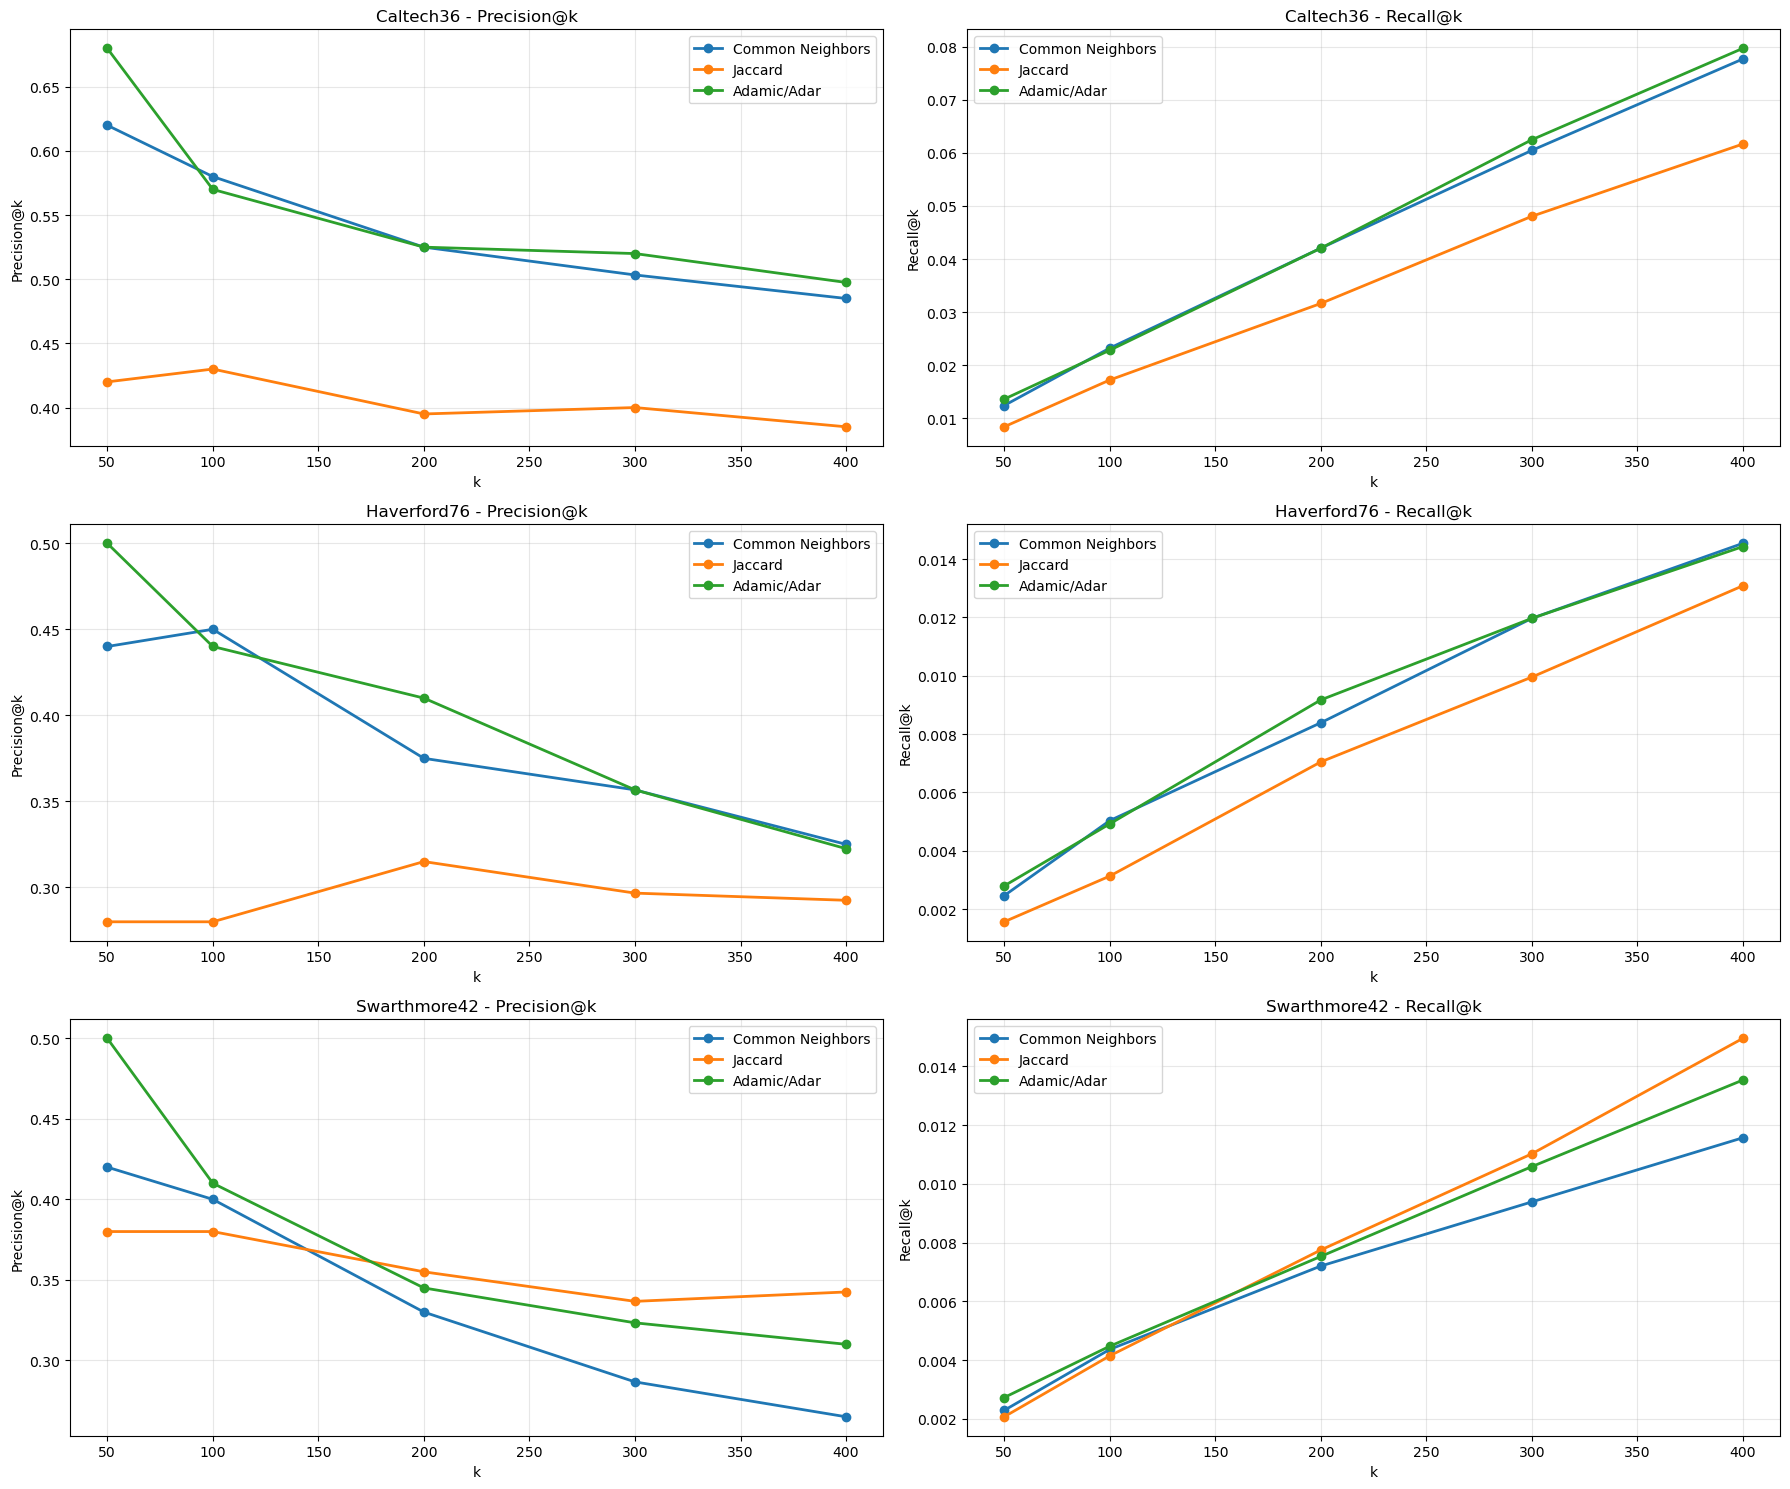

In [16]:
fraction_to_plot = 0.15

fig, axes = plt.subplots(len(networks_to_test), 2, figsize=(18, 5*len(networks_to_test)))

if len(networks_to_test) == 1:
    axes = axes.reshape(1, -1)

metrics_to_plot = ['precision', 'recall']
titles = ['Precision@k', 'Recall@k']

for net_idx, network_name in enumerate([Path(n).stem for n in networks_to_test]):
    for metric_idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[net_idx, metric_idx]
        
        data_filtered = df_results[
            (df_results['network'] == network_name) & 
            (df_results['fraction'] == fraction_to_plot)
        ]
        
        for predictor in data_filtered['predictor'].unique():
            pred_data = data_filtered[data_filtered['predictor'] == predictor]
            pred_data = pred_data.sort_values('k')
            
            ax.plot(pred_data['k'], pred_data[metric], 
                   marker='o', label=predictor, linewidth=2)
        
        ax.set_xlabel('k')
        ax.set_ylabel(title)
        ax.set_title(f'{network_name} - {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/question4/comparison_predictors_by_network_f_0_15.png', dpi=300, bbox_inches='tight')
plt.show()

### fraction = 0.2

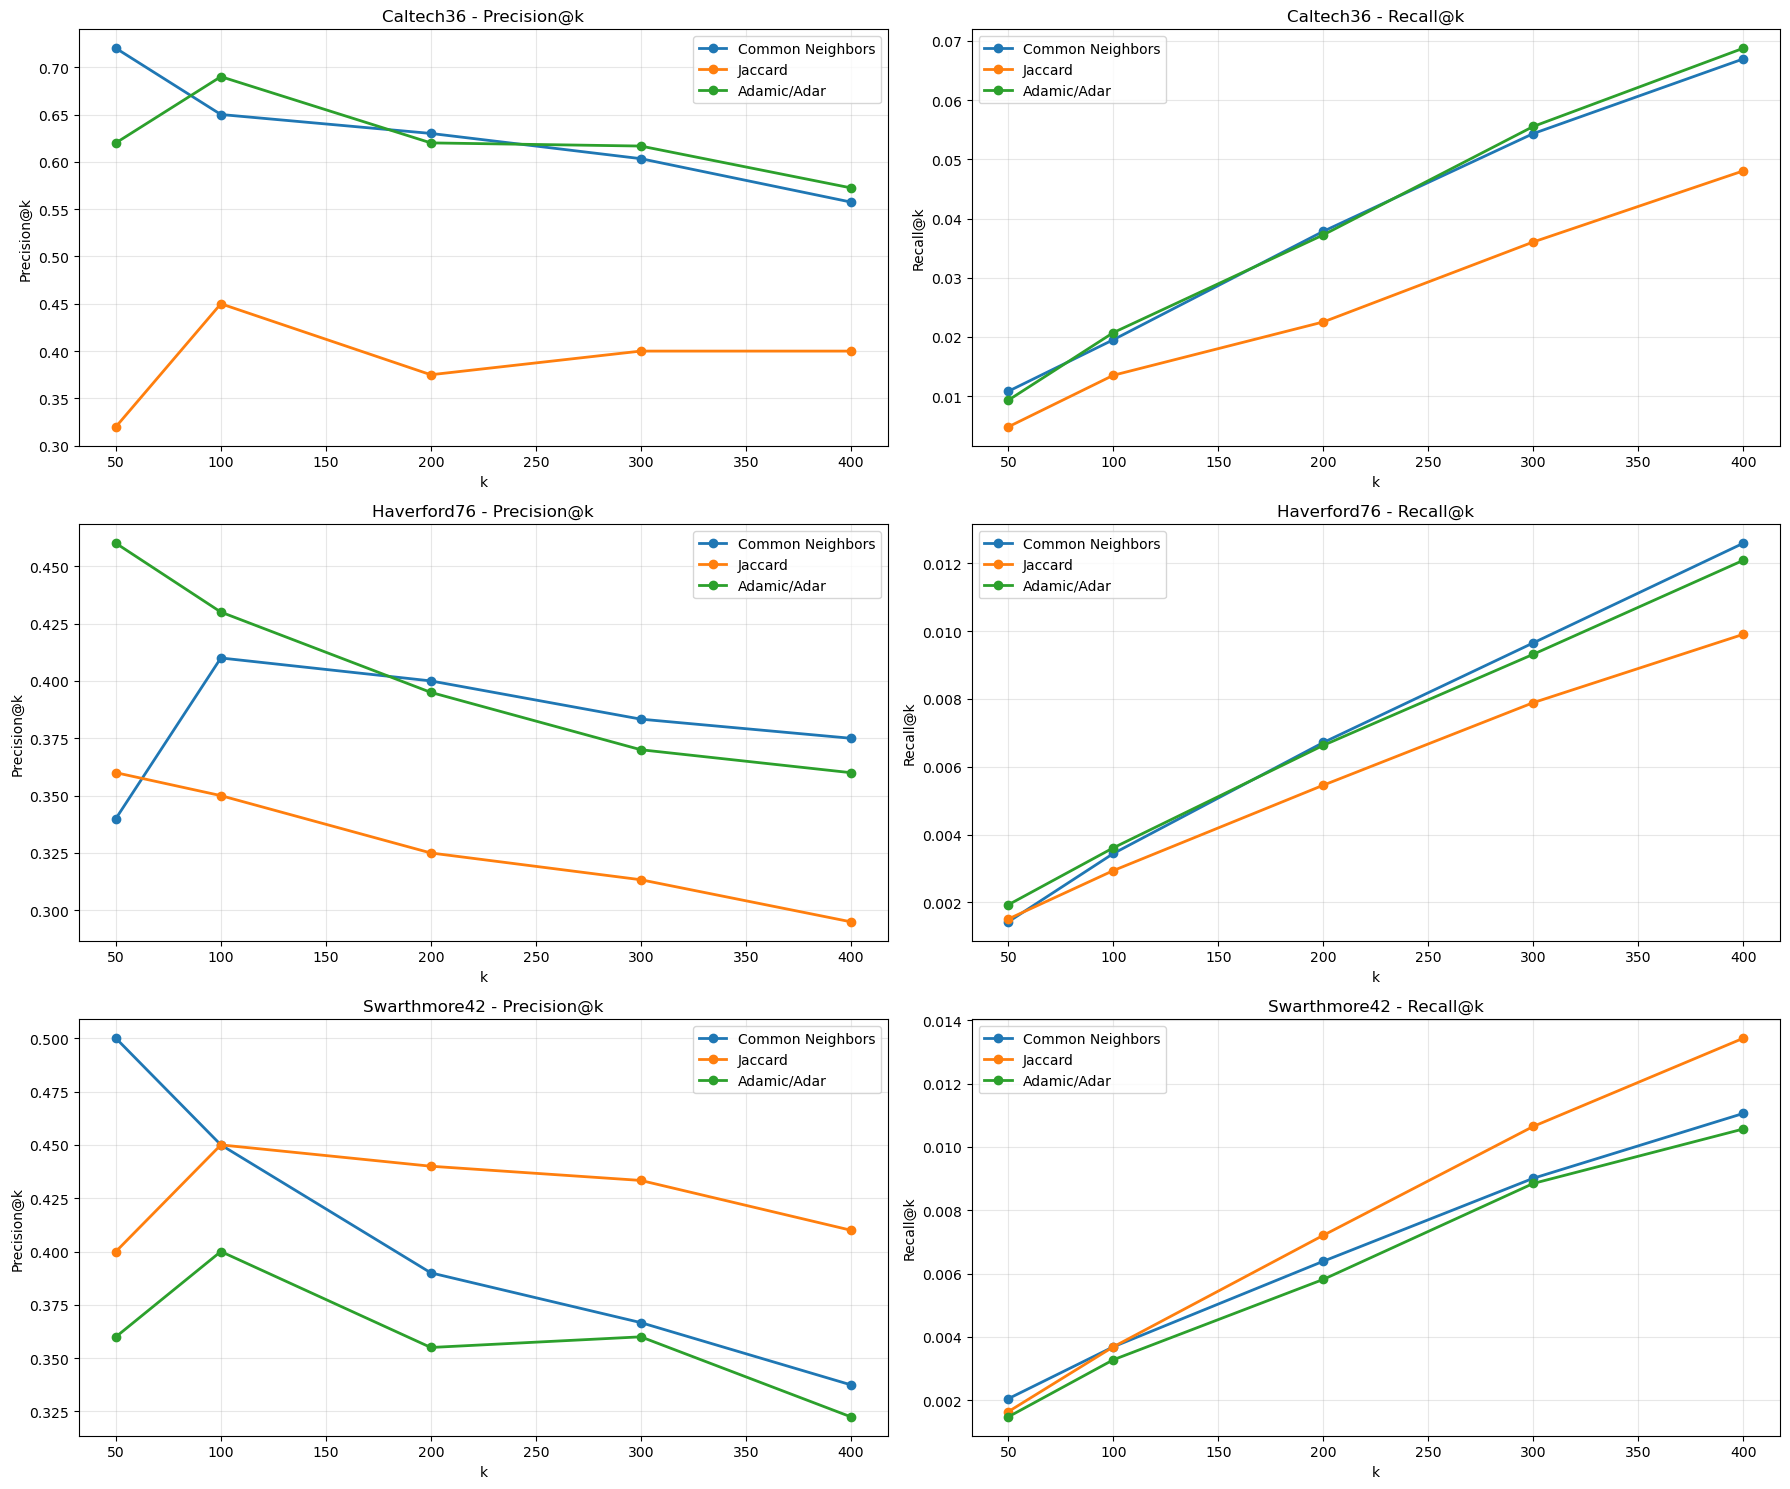

In [17]:
fraction_to_plot = 0.2

fig, axes = plt.subplots(len(networks_to_test), 2, figsize=(18, 5*len(networks_to_test)))

if len(networks_to_test) == 1:
    axes = axes.reshape(1, -1)

metrics_to_plot = ['precision', 'recall']
titles = ['Precision@k', 'Recall@k']

for net_idx, network_name in enumerate([Path(n).stem for n in networks_to_test]):
    for metric_idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[net_idx, metric_idx]
        
        data_filtered = df_results[
            (df_results['network'] == network_name) & 
            (df_results['fraction'] == fraction_to_plot)
        ]
        
        for predictor in data_filtered['predictor'].unique():
            pred_data = data_filtered[data_filtered['predictor'] == predictor]
            pred_data = pred_data.sort_values('k')
            
            ax.plot(pred_data['k'], pred_data[metric], 
                   marker='o', label=predictor, linewidth=2)
        
        ax.set_xlabel('k')
        ax.set_ylabel(title)
        ax.set_title(f'{network_name} - {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/question4/comparison_predictors_by_network_f_0_2.png', dpi=300, bbox_inches='tight')
plt.show()